In [ ]:
from google.colab import files
uploaded = files.upload()




Saving project 1.csv to project 1.csv


In [ ]:
df = pd.read_csv('project 1.csv',encoding='latin-1',nrows=1000)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Silhouette Score: 0.699


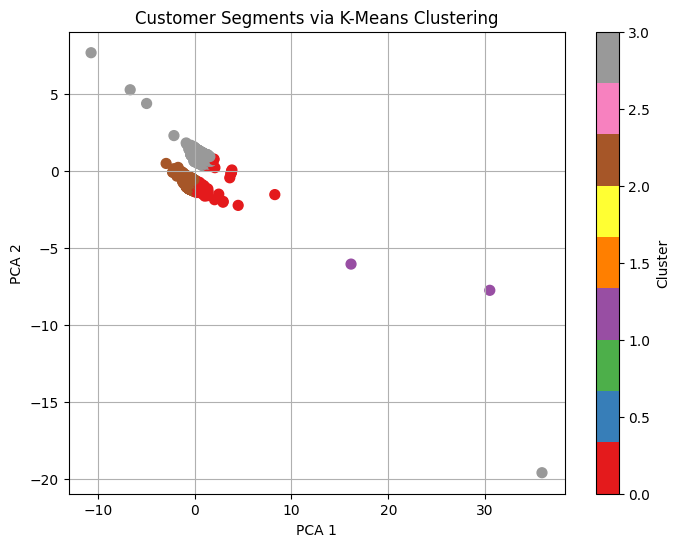


Cluster Profile Summary:
         Quantity UnitPrice CustomerID InvoiceTimestamp                  
            mean      mean    nunique              min         max count
Cluster                                                                 
0           2.31     12.50         71       1291192440  1291310340   182
1           1.00    230.00          2       1291199340  1291313160     2
2          13.12      2.36         94       1291191960  1291224900  1801
3          10.46      2.82        106       1291276080  1291313280  1810


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import random

# 1. Load the data
df = pd.read_csv('project 1.csv',encoding='latin-1',nrows=5000)
df = df[['Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate', 'Country']].dropna()

# Convert InvoiceDate to numerical (timestamp)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceTimestamp'] = df['InvoiceDate'].astype(np.int64) // 10**9
df.drop(columns=['InvoiceDate', 'Country'], inplace=True)

# 2. Normalize the data
features = ['Quantity', 'UnitPrice', 'InvoiceTimestamp']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# 3. K-Means from scratch
class KMeansScratch:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def initialize_centroids(self, data):
        indices = np.random.choice(len(data), self.k, replace=False)
        return data[indices]

    def compute_distances(self, data, centroids):
        return np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)

    def assign_clusters(self, distances):
        return np.argmin(distances, axis=1)

    def update_centroids(self, data, labels):
        return np.array([data[labels == i].mean(axis=0) for i in range(self.k)])

    def fit(self, data):
        self.centroids = self.initialize_centroids(data)
        for _ in range(self.max_iters):
            old_centroids = self.centroids
            distances = self.compute_distances(data, self.centroids)
            self.labels = self.assign_clusters(distances)
            self.centroids = self.update_centroids(data, self.labels)
            if np.all(np.linalg.norm(self.centroids - old_centroids, axis=1) < self.tol):
                break
        return self

    def predict(self, data):
        distances = self.compute_distances(data, self.centroids)
        return self.assign_clusters(distances)

# 4. Apply K-Means
kmeans = KMeansScratch(k=4)
kmeans.fit(scaled_data)
labels = kmeans.labels

# 5. Evaluate with silhouette score
score = silhouette_score(scaled_data, labels)
print(f"Silhouette Score: {score:.3f}")

# 6. Visualize with PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='Set1', s=50)
plt.title('Customer Segments via K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# 7. Add cluster labels back to original DataFrame
df['Cluster'] = labels

# 8. Profile each cluster
summary = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique',
    'InvoiceTimestamp': ['min', 'max', 'count']
}).round(2)

print("\nCluster Profile Summary:\n", summary)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('project 1.csv',encoding='latin-1',nrows=1000)
df = df[['Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate', 'Country']].dropna()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceTimestamp'] = df['InvoiceDate'].astype(np.int64) // 10**9
df.drop(columns=['InvoiceDate', 'Country'], inplace=True)

# Normalize features for clustering
features = ['Quantity', 'UnitPrice', 'InvoiceTimestamp']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# KMeans (assuming 4 clusters found)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Profile the clusters
cluster_summary = df.groupby('Cluster').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique',
    'InvoiceTimestamp': ['min', 'max', 'count']
})
print("Cluster Summary:\n", cluster_summary)

# Add labels manually based on profiling (example — adjust as per your results)
cluster_labels = {
    0: 'Frequent Buyer',
    1: 'High Spender',
    2: 'Low Value',
    3: 'New Customer'
}
df['Segment'] = df['Cluster'].map(cluster_labels)

# Prepare data for classifier
X = df[['Quantity', 'UnitPrice', 'InvoiceTimestamp']]
y = df['Segment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test
y_pred = clf.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Cluster Summary:
            Quantity   UnitPrice CustomerID InvoiceTimestamp                  
               mean        mean    nunique              min         max count
Cluster                                                                      
0          7.383966    2.609128         26       1291200660  1291207380   711
1          1.000000  165.000000          1       1291199340  1291199340     1
2        446.400000    1.286000          4       1291197480  1291206420     5
3         18.602837    3.583652         24       1291191960  1291200720   282
Confusion Matrix:
 [[149   0]
 [  1  50]]

Classification Report:
                 precision    recall  f1-score   support

Frequent Buyer       0.99      1.00      1.00       149
  New Customer       1.00      0.98      0.99        51

      accuracy                           0.99       200
     macro avg       1.00      0.99      0.99       200
  weighted avg       1.00      0.99      0.99       200



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv('project 1.csv', encoding='latin-1', nrows=5000)
df = df[['Quantity', 'UnitPrice', 'CustomerID', 'InvoiceDate']].dropna()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceTimestamp'] = df['InvoiceDate'].astype(np.int64) // 10**9

# Normalize features for clustering
features = ['Quantity', 'UnitPrice', 'InvoiceTimestamp']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Assign labels based on profiling
cluster_labels = {
    0: 'Frequent Buyer',
    1: 'Medium Buyer',
    2: 'High Buyer'
}
df['Segment'] = df['Cluster'].map(cluster_labels)

# Profile the clusters
cluster_summary = df.groupby('Segment').agg({
    'Quantity': 'mean',
    'UnitPrice': 'mean',
    'CustomerID': 'nunique'
})
print("Cluster Summary:\n", cluster_summary)


Cluster Summary:
                    Quantity  UnitPrice  CustomerID
Segment                                           
Frequent Buyer    15.502191   3.200433         107
High Buyer        12.211382   3.170843          98
Medium Buyer   -9360.000000   0.030000           1
